# 03— ICD-9 Diagnostic Codes (Feature Extraction)

This notebook prototypes the feature extraction from the ICD-9 data, that will go into the workflow in extract_diag.py

**Local data source:** `/data/interim/10kDiabetes.csv`

In [1]:
import sys
import os

project_root = os.path.abspath("..") # Add project root to Python path so we can import data_loader
if project_root not in sys.path:
    sys.path.append(project_root)

project_root

'C:\\work\\git\\diabetes-readmission-ml'

In [2]:
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore") # Not too bothered about message "Pyarrow will become a required dependency of pandas"
    import pandas as pd
    from IPython.core.display import display, HTML

import numpy as np
import missingno as msno
import re
import itertools

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid", font_scale=1.4)  # try 1.3–1.6

from src.data_loader import load_diabetes_csv, DIABETES_DATA_CSV

plt.style.use("seaborn-v0_8")
pd.set_option("display.max_columns", None)

In [3]:
df = load_diabetes_csv(DIABETES_DATA_CSV,project_root)
df.shape

(10000, 52)

In [4]:
df[["diag_1", "diag_2", "diag_3"]].head(10)

,diag_1,diag_2,diag_3
0,723,723,719
1,664,648,285
2,481,428,276
3,682,41,250
4,296,250.01,298
5,428,427,414
6,434,345,584
7,558,562,455
8,428,425,70
9,440,998,998


In [5]:
def normalize_icd(code):
    """
    Normalise ICD-9 code into one of:
      - integer parent for numeric codes
      - original string for V/E codes
      - None otherwise
    """
    if pd.isna(code):
        return None
    
    code = str(code).strip()
    if code.startswith(("V", "E")):
        return code
    try:
        return int(float(code)) # Note you can't go directly to int as int('250.01') will fail. Hence the double-tap.
    except Exception:
        return None

In [6]:
( normalize_icd('250'), normalize_icd('250.01'), normalize_icd('E939'), normalize_icd('V63'), normalize_icd('?') )

(250, 250, 'E939', 'V63', None)

In [7]:
diag_cols = ["diag_1", "diag_2", "diag_3"]

for col in diag_cols:
    df[f"{col}_norm"] = df[col].apply(normalize_icd)

In [8]:
df_tmp = df.copy() 
df_tmp['1→2'] = '|'
df_tmp['2→3'] = '|'
df_tmp = df_tmp[['diag_1','diag_1_norm', '1→2', 'diag_2','diag_2_norm','2→3', 'diag_3','diag_3_norm']]
df_tmp.head(25)

,diag_1,diag_1_norm,1→2,diag_2,diag_2_norm,2→3,diag_3,diag_3_norm
0,723,723,|,723,723,|,719,719
1,664,664,|,648,648,|,285,285
2,481,481,|,428,428,|,276,276
3,682,682,|,41,41,|,250,250
4,296,296,|,250.01,250,|,298,298
5,428,428,|,427,427,|,414,414
6,434,434,|,345,345,|,584,584
7,558,558,|,562,562,|,455,455
8,428,428,|,425,425,|,70,70
9,440,440,|,998,998,|,998,998


In [9]:
def has_V(lst):
    return int(any(isinstance(c, str) and c.startswith("V") for c in lst))

def has_E(lst):
    return int(any(isinstance(c, str) and c.startswith("E") for c in lst))

In [10]:
df["diag_norm_list"] = df[[f"{c}_norm" for c in diag_cols]].apply(list, axis=1)

df["has_V"] = df["diag_norm_list"].apply(has_V)
df["has_E"] = df["diag_norm_list"].apply(has_E)

In [11]:
df["diag_count"] = df["diag_norm_list"].apply(
    lambda lst: len({c for c in lst if c is not None})
)

In [12]:
display(
    df[
        [
            "diag_1","diag_2","diag_3",
            "diag_1_norm","diag_2_norm","diag_3_norm",
            "has_V","has_E","diag_count"
        ]
    ].sample(10)
)

,diag_1,diag_2,diag_3,diag_1_norm,diag_2_norm,diag_3_norm,has_V,has_E,diag_count
7702,996,38,995,996,38,995,0,0,3
4682,560,250,401,560,250,401,0,0,3
3269,427,458,250,427,458,250,0,0,3
5594,490,244,401,490,244,401,0,0,3
3064,786,426,401,786,426,401,0,0,3
2493,70,573,426,70,573,426,0,0,3
2956,780,907,438,780,907,438,0,0,3
3010,682,250.81,250.6,682,250,250,0,0,2
6783,715,278,250,715,278,250,0,0,3
6108,574,287,250,574,287,250,0,0,3


<Axes: >

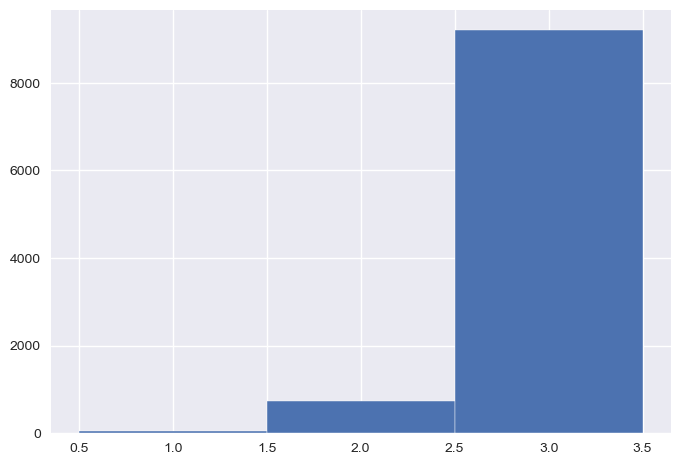

In [13]:
df['diag_count'].hist(bins=[0.5, 1.5, 2.5, 3.5])

In [14]:
histogram_data = df.groupby('diag_count').count()['rowID']
print(histogram_data.sum())
histogram_data

10000


diag_count
1      53
2     741
3    9206
Name: rowID, dtype: int64

## We now have some interesting new synthetic features

In [27]:
df_synthetic_feat = df[['diag_count', 'has_V', 'has_E', 'readmitted']]
df_synthetic_feat.head()

,diag_count,has_V,has_E,readmitted
0,2,0,0,False
1,3,0,0,False
2,3,0,0,True
3,3,0,0,False
4,3,0,0,False


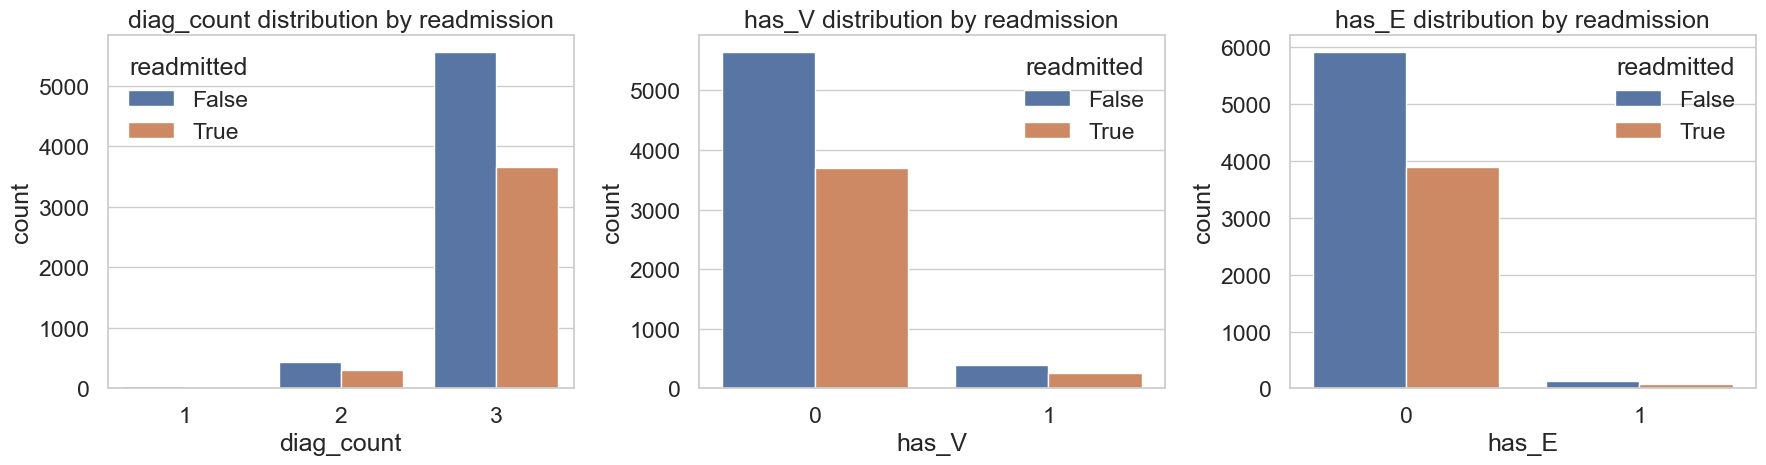

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

features = ["diag_count", "has_V", "has_E"]

for ax, feat in zip(axes, features):
    sns.countplot(
        data=df_synthetic_feat,
        x=feat,
        hue="readmitted",
        ax=ax
    )
    ax.set_title(f"{feat} distribution by readmission")
    ax.set_xlabel(feat)
    ax.set_ylabel("count")

plt.tight_layout()
plt.show()

## This suggests:
1. diag_count should be excluded from my final model, being overwhelmingly concentrated at 3
2. has_V should be excluded, because V-codes are extremely sparse (<5% of cases)
3. has_E should be excluded, because E-codes are even rarer than V-codes